# Analysis GAIA M67 DR2
### Packages

In [137]:
import astropy.units as u  # Simplify unity manipulation
from astropy.coordinates import SkyCoord # To handle sky/space coordinates
from astroquery.gaia import Gaia
from astropy.io.votable import parse

from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Reading votable & data manipulation fonctions

In [326]:
## Reading the votable
def reading_votable(path_voname) :
    votable = parse(path_voname)
    for table in votable.iter_tables():
        data = table.array
        #print(data.dtype.names)
    return data

## Convert data to array
def convert_data(data) :
    # Getting variables
    lgal = data['l']
    bgal = data['b']
    pmas = data['parallax']
    distance = 1000. / np.ma.filled(pmas, -9999999.) #distance = 1000/parallax
    pmra = np.ma.filled(data['pmra'], -9999999.) # right assention
    pmdec= np.ma.filled(data['pmdec'],-9999999.) #proper motion declinente
    vdec = 4.74 * pmdec / pmas   ##? (pour )
    vra  = 4.74 * pmra  / pmas   # pour avoir des km.s-1
    
    #para_abs_error = data['parallax_error']/data['parallax']
    g = data['phot_g_mean_mag']; bp = data['phot_bp_mean_mag']; rp = data['phot_rp_mean_mag']
    
    #filtering
    dist_range = [0., 2000]; vra_range = [-200,200]; vdec_range = [-200.,200]
    
    i1 = np.where((distance >= dist_range[0]) & (distance < dist_range[1]))
    i2 = np.where((vra >= vra_range[0]) & (vra < vra_range[1]))
    i12 = np.intersect1d(i1,i2)
    i3 = np.where((vdec >= vdec_range[0]) & (vdec < vdec_range[1]))
    ifinal = np.intersect1d(i12,i3)
    
    return np.array([lgal[ifinal], bgal[ifinal], distance[ifinal], vra[ifinal], vdec[ifinal],
                     g[ifinal], bp[ifinal], rp[ifinal]]).T

#conversion of lgal, bgal, distance into cartesian coordinate
def convert_to_cartesian(lgal, bgal, dist, centering = True):
    #centering True = x coordinate point to cluster center
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal));  yy = np.zeros(len(lgal));  zz = np.zeros(len(lgal))
    
    lgalOff = lgal - np.mean(lgal)
    bgalOff = bgal - np.mean(bgal)
    
    
    for i in range(len(lgal)):
        c = SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    return np.array([xx,yy,zz]).T

### Getting data
#### - data = [$lgal$, $bgal$, $distance$, $vra$, $vdec$, $g$, $b_p$, $r_p$]

In [327]:
## Reading the votable
voname = "M67.vot"

raw_data = reading_votable(voname)
print(voname+"\n## Total stars: %d"%(len(raw_data)))

# Select variables and Clean wrong values, return 2d array
data = convert_data(raw_data)
print("## Stars selected: %d"%(len(data[:,0])))

#cartesian coordinate data
data_cartesian = np.zeros(data.shape)
data_cartesian[:,:3] = convert_to_cartesian(data[:,0],data[:,1],data[:,2],True)

M67.vot
## Total stars: 19449
## Stars selected: 10818


In [328]:
voname = "M67_error_filtered.vot"
raw_data = reading_votable(voname)
print(voname+"\n## Total stars: %d"%(len(raw_data)))
data2 = convert_data(raw_data)
print("## Stars selected: %d"%(len(data2[:,0])))
data2_cartesian = np.zeros(data2.shape)
data2_cartesian[:,:3] = convert_to_cartesian(data2[:,0],data2[:,1],data2[:,2],True)

M67_error_filtered.vot
## Total stars: 1456
## Stars selected: 1441


In [329]:
voname = "NGC2516.vot"
raw_data = reading_votable(voname)
print(voname+"\n## Total stars: %d"%(len(raw_data)))
data3 = convert_data(raw_data)
print("## Stars selected: %d"%(len(data3[:,0])))
data3_cartesian = np.zeros(data3.shape)
data3_cartesian[:,:3] = convert_to_cartesian(data3[:,0],data3[:,1],data3[:,2],True)

NGC2516.vot
## Total stars: 79407
## Stars selected: 67190


### Normalisation Fonctions

In [188]:
# normalize the 5d datask and also return the normalization vector
# choix_norm = 0 (norme 0) et = 1 (norm 2)
def normalization(data,choix_norm=1):
    result = np.zeros(data.shape)
    normalization_vector = np.zeros(5)
    
    for i in range(5) :
        if choix_norm == 0 : normalization_vector[i] = np.max(abs(data[:,i]))
        else               : normalization_vector[i] = np.linalg.norm(data[:,i])
        result[:,i] = data[:,i]/normalization_vector[i]
    
    return(result,normalization_vector)


#Normalized the 5d datask with linear projection from [min,max] to [0,1]
def normalization0_1(data, weight = np.array([1,1,1,1,1])):
    result = np.zeros(data.shape)
    normalization_vector = np.zeros((5,2)) #Represente max and min    
    
    for i in range(5) :
        normalization_vector[i,0] = np.max(data[:,i]) # max
        normalization_vector[i,1] = np.min(data[:,i]) # min
        result[:,i] = weight[i]*(data[:,i]-normalization_vector[i,1])/(normalization_vector[i,0]-normalization_vector[i,1])  
        
    return(result,normalization_vector)

#Unnormalized Data with linear projection from [0,1] to [min,max]
def unnormalization0_1(data, normalization_vector, weight = np.array([1,1,1,1,1])):
    result = np.zeros(data.shape) 
    for i in range(5) :
        result[:,i] = data[:,i]*(normalization_vector[i,0]-normalization_vector[i,1])/weight[i] + normalization_vector[i,1]
        
    return result

### Data processing

In [190]:
# weight vector to allocate to each component
weight = [1, 1, 1, 1, 1]

In [244]:
print("## Total stars: %d"%(len(lgal)))

# Clean wrong values, return (n,5) array
datask = filter_data(lgal,bgal,distance,vra,vdec, cartesian = True)
print("## Stars selected: %d"%(len(datask[:,0])))

#datanor0, normalization_vector0 = normalization(datask,0)
#datanor1, normalization_vector1 = normalization(datask,1)
#datanor2, normalization_vector2 = normalization0_1(datask, weight)

# Normalization
# datask  =  non-normalized
# datanor0 = normalized norm0 (divided by max(abs(data)))
# datanor1 = normalized norm2 (divided by np.linalg.norm(data[:,i]))
# datanor2 = linear projection from [min,max] to [0,1]

## Total stars: 19449
## Stars selected: 10818


In [218]:
distance_error = data['parallax_error']*1000./(data['parallax']**2)
dist_abs_error = distance_error/distance
para_abs_error = data['parallax_error']/data['parallax']
datask2 = filter_data2(lgal,bgal,distance,vra,vdec,para_abs_error, cartesian = True)

In [169]:
# Useful tab
colors = ['b','r','g','c','m','y','k','turquoise','orangered','darkgreen','sienna','navy','orangered','darkred','green','springgreen','turquoise','violet']
string = ['non-normalized','normalized norm 0', 'normalized norm 2','normalized linearly between 0 and 1']
data_name = ['lgal','bgal','distance','vdec','vra']

## Data plotting

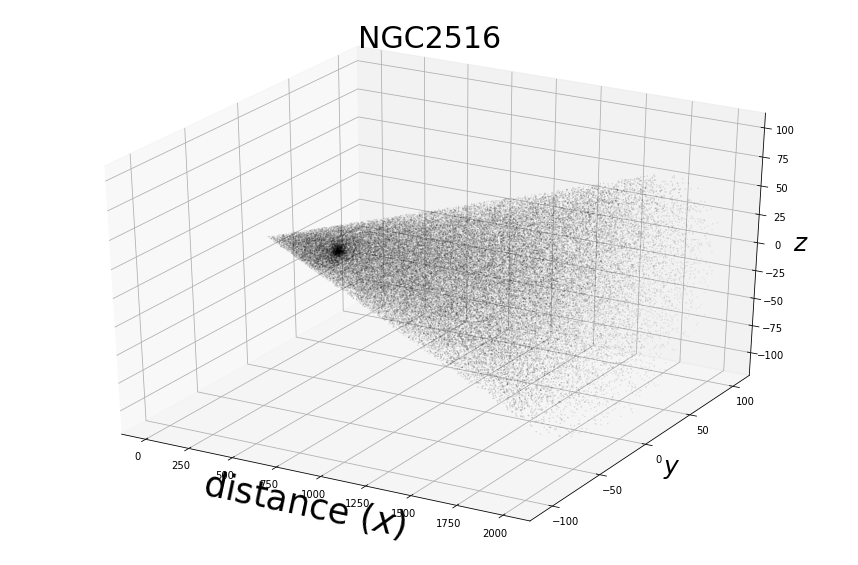

In [410]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data3_cartesian[:,0], data3_cartesian[:,1], data3_cartesian[:,2], zdir='z', s=0.01, c='k', depthshade=True)
ax.set_xlabel('distance ($x$)', fontsize=35); ax.set_ylabel('$y$', fontsize=25); ax.set_zlabel('$z$', fontsize=25)
ax.set_title('NGC2516', fontsize=30)
#ax.view_init(30, 60)
plt.show()

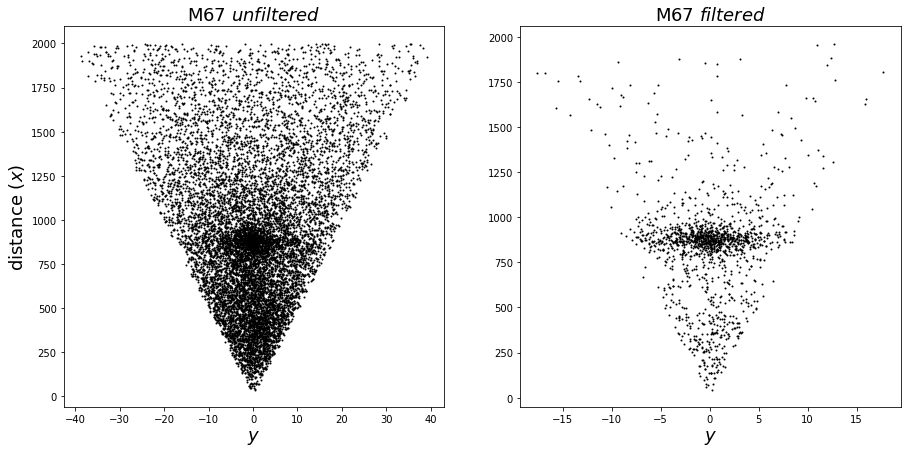

In [414]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title('M67 $unfiltered$', fontsize=18)
plt.scatter(data_cartesian[:,1],data_cartesian[:,0],s=1,c='k')
plt.ylabel('distance ($x$)', fontsize=18)
plt.xlabel('$y$', fontsize=18); plt.subplot(122); plt.xlabel('$y$', fontsize=18)
plt.title('M67 $filtered$', fontsize=18)
plt.scatter(data2_cartesian[:,1],data2_cartesian[:,0],s=1,c='k')
plt.show()

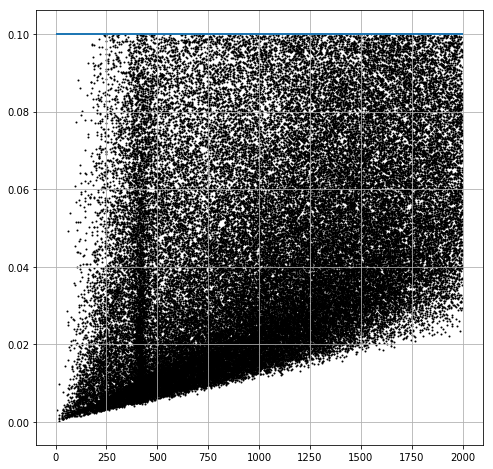

In [306]:
plt.scatter(data3_cartesian[:,0],data3_cartesian[:,5],s=1,c='k')
plt.plot(data3_cartesian[:,0],0.1*np.ones(len(data3_cartesian[:,0])))
plt.grid(True)
plt.show()

### RGB Plotting

In [390]:
# Plot the HD diagram
def HRD(data, data_name, size=0.1, colorbar = True) :
    parallax = 1000./data[:,2]
    
    G_bar = data[:,5] + 5*np.log10(parallax) + 2
    G_max = np.max(G_bar)
    G_min = np.min(G_bar)
    
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title(data_name, fontsize=20)
    if colorbar : 
        plt.scatter(data[:,6]-data[:,5], G_bar, s=size, c=data[:,2], cmap='gist_stern')
        clb = plt.colorbar()
        clb.set_label('distance', labelpad=-40, y=1.05, rotation=0)
    else : plt.scatter(data[:,6]-data[:,5], G_bar, s=1, c='k')
    plt.ylim(G_max, G_min)
    plt.xlabel('$B_p - G$', fontsize=18)
    plt.ylabel(r'$G + 5 * log_{10}\bar{\omega} + 2$', fontsize=22)
    plt.subplot(122)
    plt.title(data_name, fontsize=20)
    if colorbar : 
        plt.scatter(data[:,5]-data[:,7], G_bar, s=size, c=data[:,2], cmap='gist_stern')
        clb = plt.colorbar()
        clb.set_label('distance', labelpad=-40, y=1.05, rotation=0)
    else : plt.scatter(data[:,5]-data[:,6], G_bar, s=1, c='k')
    plt.ylim(G_max, G_min)
    plt.xlabel('$G - R_p$', fontsize=18)
    plt.show()

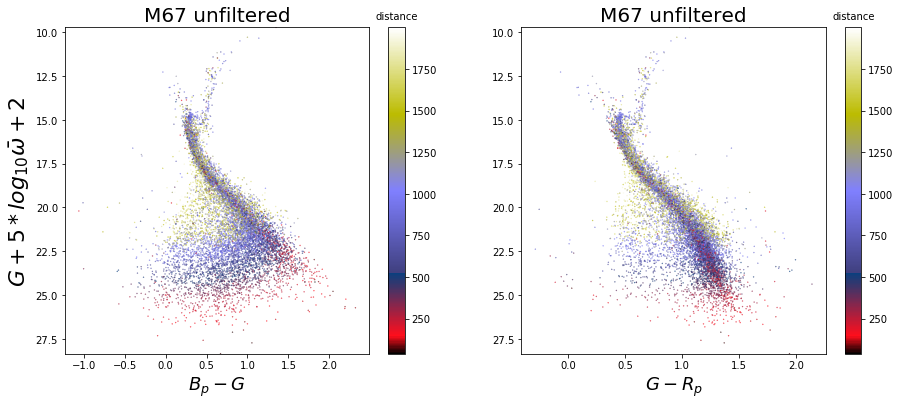

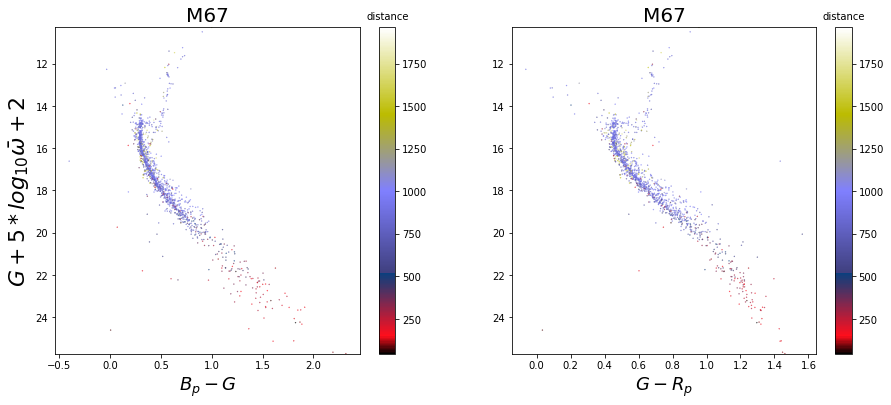

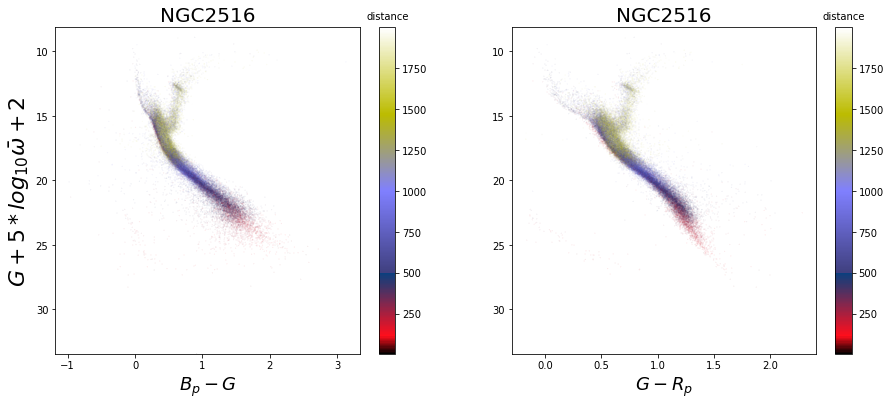

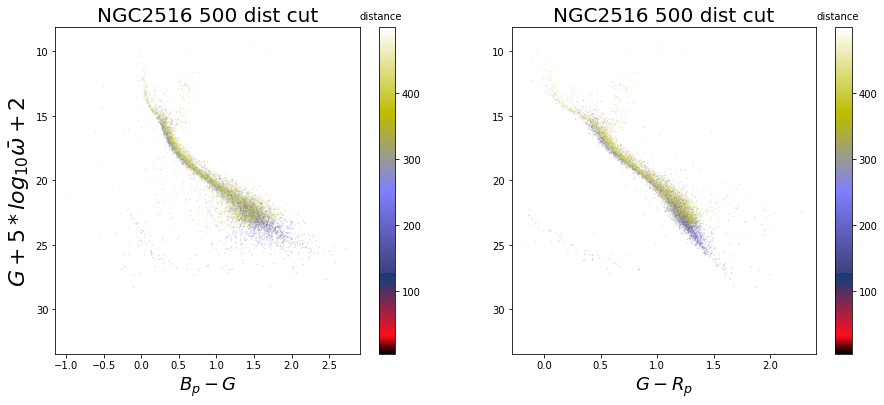

In [415]:
HRD(data, "M67 unfiltered", size=0.1, colorbar=True)
HRD(data2, "M67", size=0.1, colorbar=True)
HRD(data3, "NGC2516", size=0.001, colorbar=True)
i1 = np.where((data3[:,2] < 500))[0]
HRD(data3[i1,:], "NGC2516 500 dist cut", size=0.01, colorbar=True)

# -----------------
## Plotting before clustering

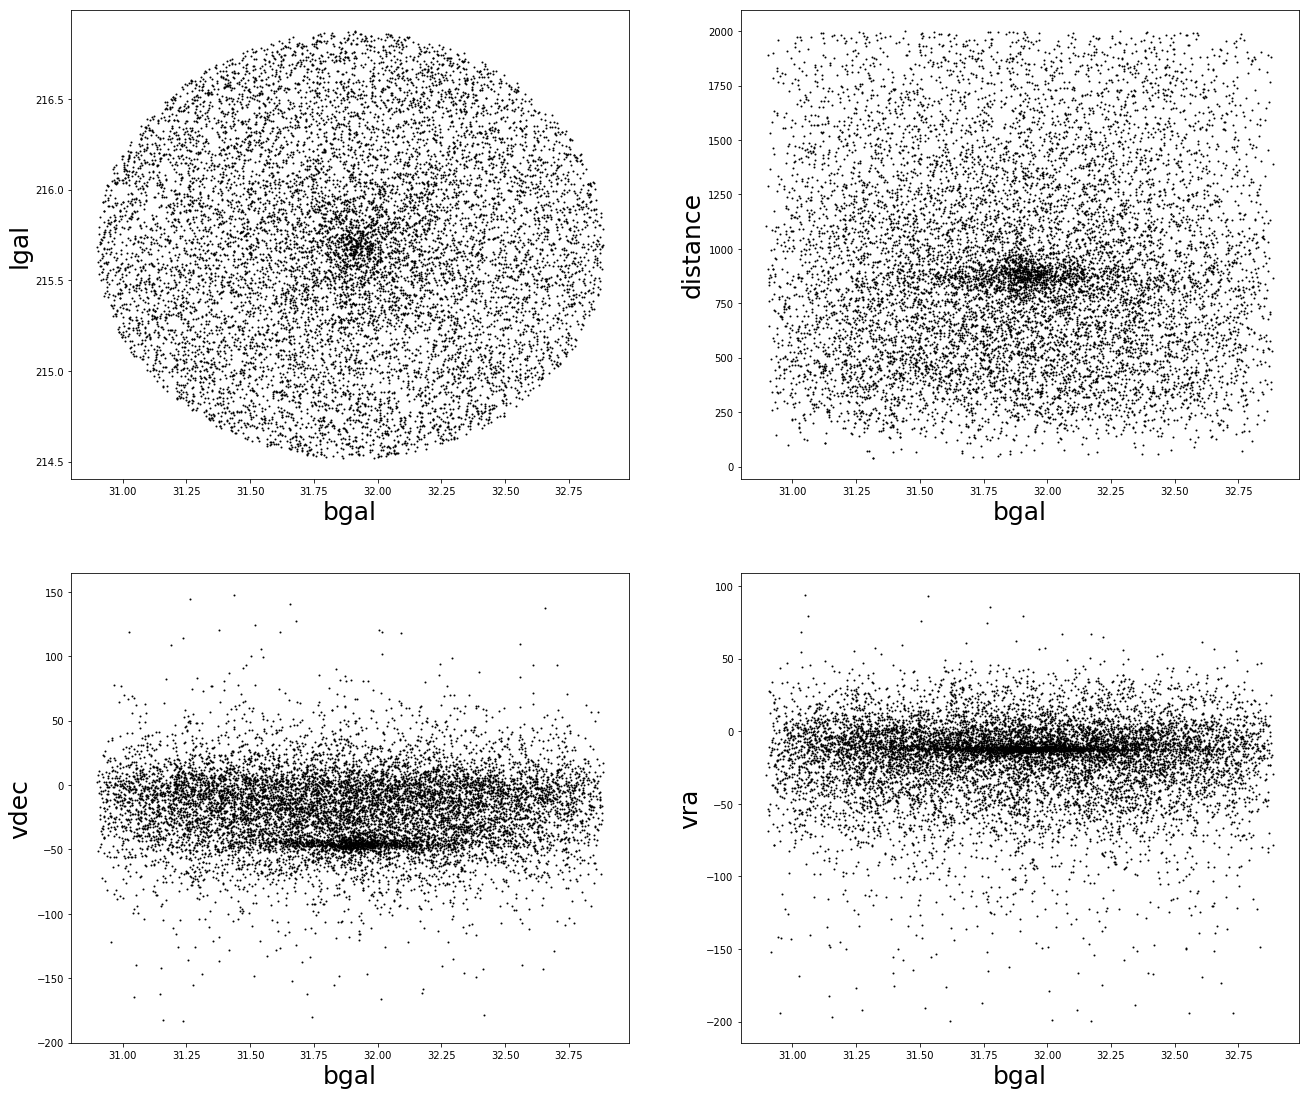

In [128]:
plt.figure(figsize=(22,19))

for i in (0,2,3,4) :
    if i == 0 : j = 1
    else      : j = i
    plt.subplot(2,2,j)
    plt.scatter(datask[:,1],datask[:,i],s=1,c='k')
    plt.xlabel(data_name[1], fontsize=25)
    plt.ylabel(data_name[i], fontsize=25)
plt.show()

## Clustering

In [81]:
## fitted cluster in k-means
nclust = 12
print("## computing k-means...")

# KMeans for each normalisation
kmeans = KMeans(n_clusters=nclust, max_iter = 2000, n_init = 50)
kmeans.fit(datask)
kmeans_nor0 = KMeans(n_clusters=nclust, max_iter = 2000, n_init = 50)
kmeans_nor0.fit(datanor0)
kmeans_nor1 = KMeans(n_clusters=nclust, max_iter = 2000, n_init = 50)
kmeans_nor1.fit(datanor1)
kmeans_nor2 = KMeans(n_clusters=nclust, max_iter = 2000, n_init = 50)
kmeans_nor2.fit(datanor2)

# Centroid for each normalisation
centroid = kmeans.cluster_centers_
centroid_nor0 = np.multiply(kmeans_nor0.cluster_centers_, normalization_vector0)
centroid_nor1 = np.multiply(kmeans_nor1.cluster_centers_, normalization_vector1)
centroid_nor2 = unnormalization0_1(kmeans_nor2.cluster_centers_, normalization_vector2, weight)

# Labels for each normalisation
labels = kmeans.labels_
labels_nor0 = kmeans_nor0.labels_
labels_nor1 = kmeans_nor1.labels_
labels_nor2 = kmeans_nor2.labels_

## computing k-means...


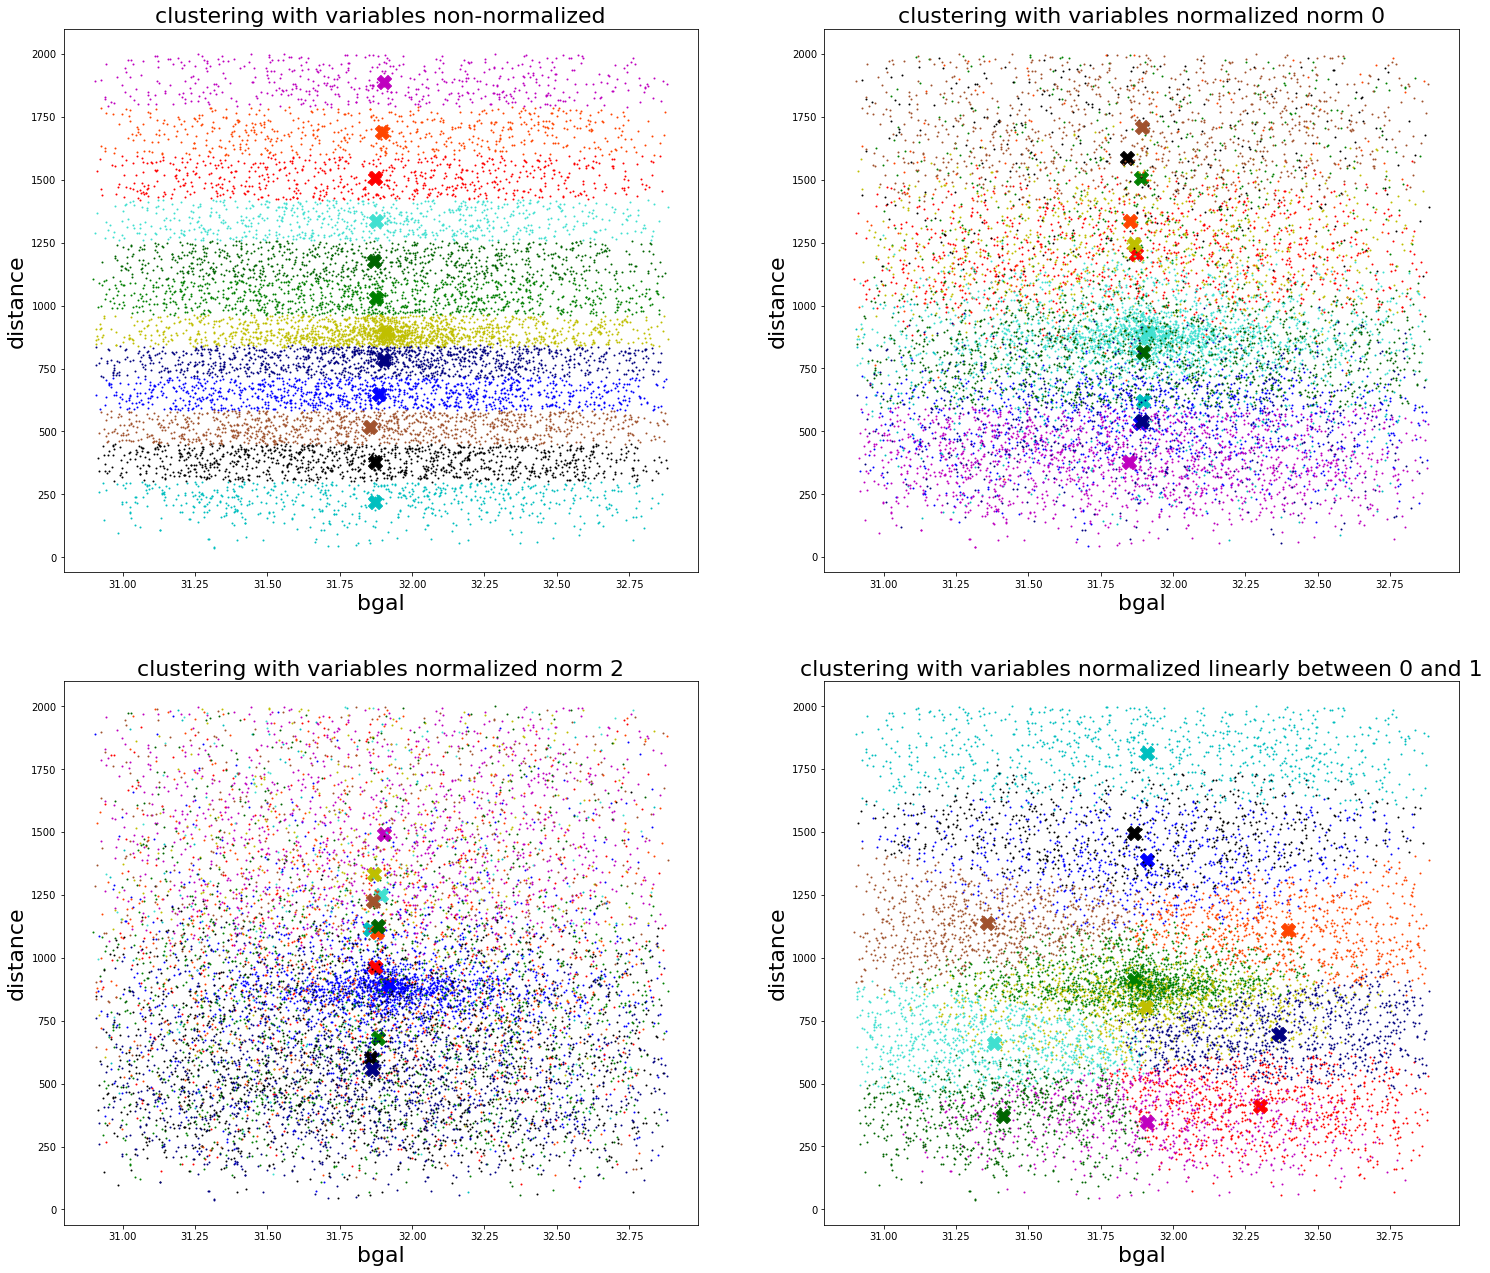

In [92]:
# Plotting i2 with respect to i1
# (0 = lgal; 1 = bgal; 2 = distance...)
i1 = 1
i2 = 2

j = 1
plt.figure(figsize=(25,22))
centro = [centroid,centroid_nor0,centroid_nor1,centroid_nor2]
for lab in (labels,labels_nor0,labels_nor1,labels_nor2) :
    plt.subplot(2,2,j)
    for i in range(nclust):
        ilabel = np.where(lab == i)[0]
        plt.scatter(datask[ilabel,i1],datask[ilabel,i2],s=1,c=colors[i])
        plt.scatter(centro[j-1][i,i1],centro[j-1][i,i2],s=200,c=colors[i],marker='X')
    plt.xlabel(data_name[i1], fontsize=22)
    plt.ylabel(data_name[i2], fontsize=22)
    plt.title("clustering with variables " + string[j-1], fontsize=22)
    j+=1
    
plt.show()

### Cluster plotting for data normalized linearly between 0 and 1

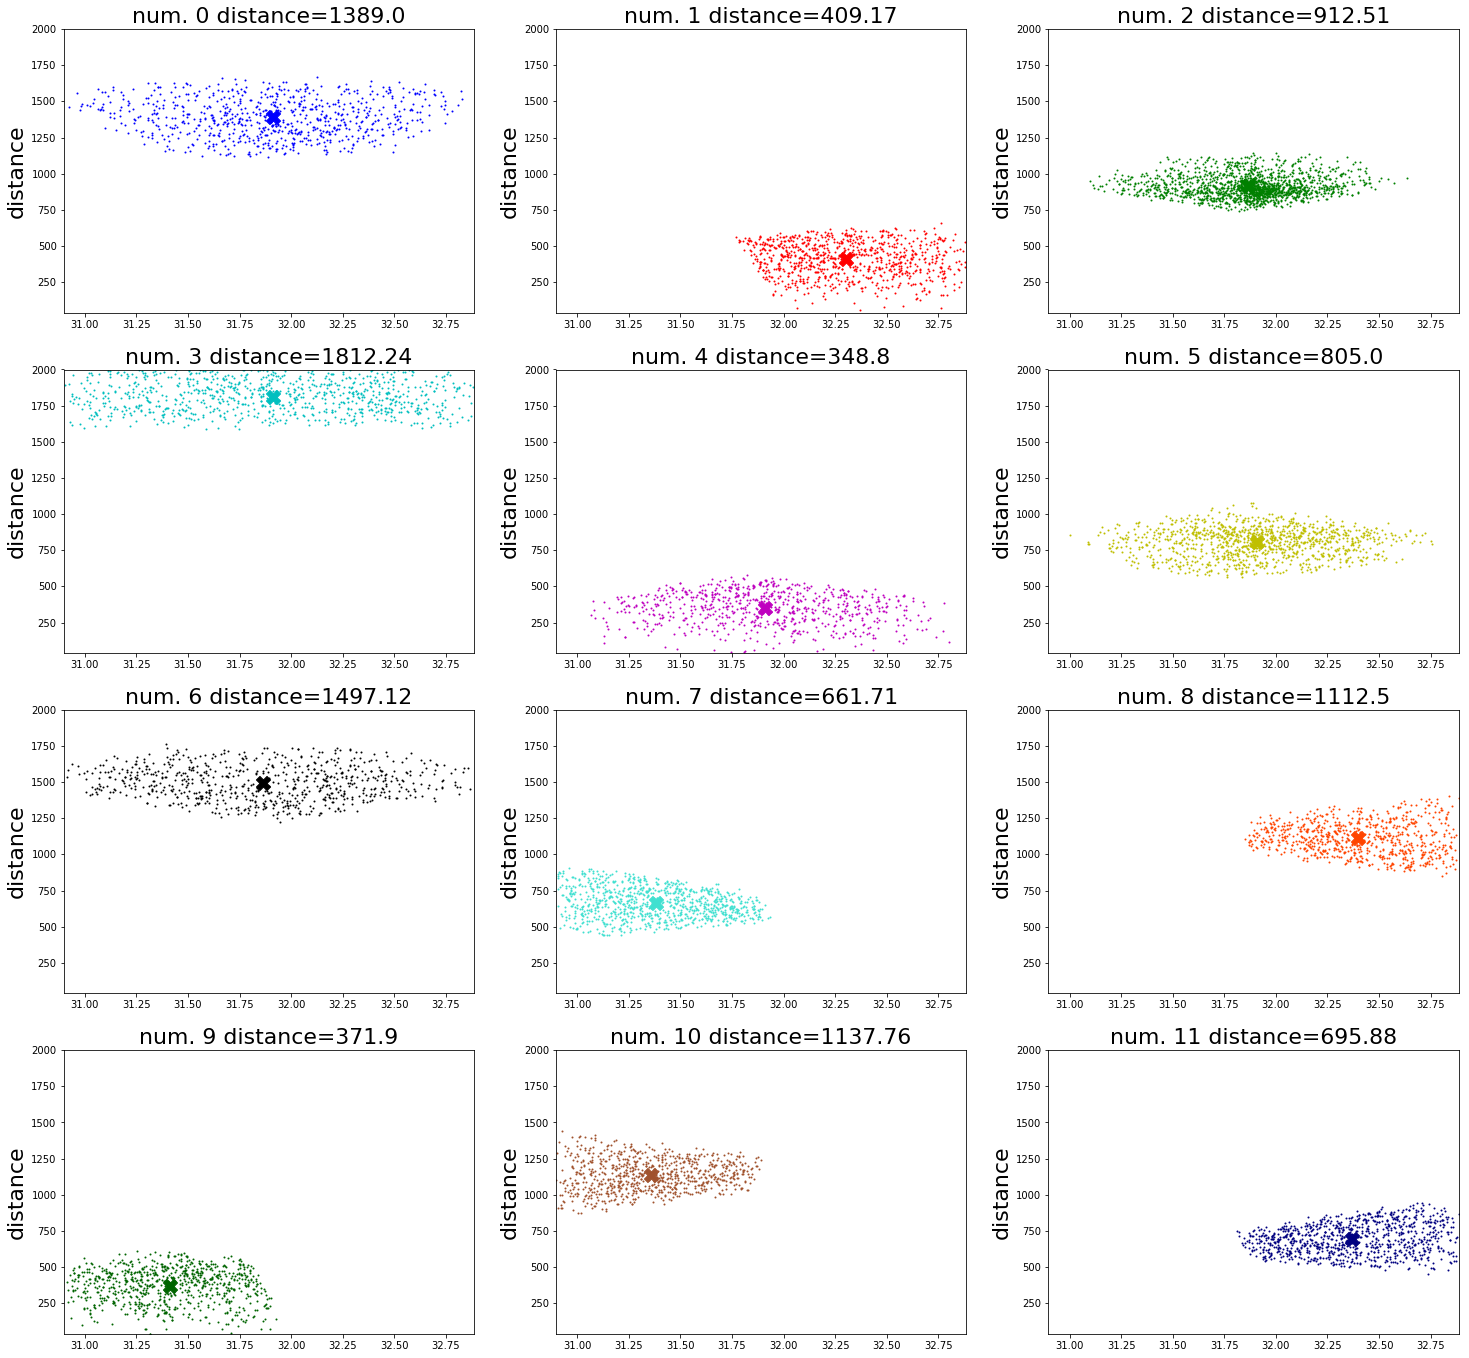

In [116]:
# Plotting i2 with respect to i1
# (0 = lgal; 1 = bgal; 2 = distance...)
i1 = 1
i2 = 2

plt.figure(figsize=(25,((nclust-1)//3+1)*6))
for i in range(nclust):
    plt.subplot((nclust-1)//3+1,3,i+1)
    ilabel = np.where(labels_nor2 == i)[0]
    plt.scatter(datask[ilabel,i1],datask[ilabel,i2],s=1,c=colors[i])
    plt.scatter(centroid_nor2[i,i1],centroid_nor2[i,i2],s=200,c=colors[i],marker='X')
    #plt.xlabel(data_name[i1], fontsize=22)
    plt.ylabel(data_name[i2], fontsize=22)
    plt.title("num. " + str(i) + " " + data_name[i2] + "=" + str(round(centroid_nor2[i,i2],2)), fontsize=22)
    plt.xlim(np.min(datask[:,i1]), np.max(datask[:,i1]))
    plt.ylim(np.min(datask[:,i2]), np.max(datask[:,i2]))
    
plt.show()

In [ ]:
#for d in (1,2,3,4,5,8,10) :
d = 2
weight = [1, 1, d, 1, 1]
data01, normalization_vector01 = normalization0_1(datask, weight)

plt.figure(figsize=(25,23))
i1 = 1
i2 = 2

for n in range(2,14) :

    kmeans_01 = KMeans(n_clusters=n, max_iter = 2000, n_init = 50)
    kmeans_01.fit(data01)

    centroid_01 = unnormalization0_1(kmeans_01.cluster_centers_, normalization_vector01, weight)
    labels_01 = kmeans_01.labels_


    plt.subplot(4,3,n-1)
    for i in range(n):
        ilabel = np.where(labels_01 == i)[0]
        plt.scatter(datask[ilabel,i1],datask[ilabel,i2],s=1,c=colors[i])
        plt.scatter(centroid_01[i,i1],centroid_01[i,i2],s=200,c=colors[i],marker='X')
    plt.xlabel(data_name[i1], fontsize=22)
    plt.ylabel(data_name[i2], fontsize=22)
    plt.title("num. of cluster : " + str(n), fontsize=22)
#plt.savefig('kmeans_cluser_[1-1-%s-1-1].png'%(d))
plt.show()

# -------------------------------------------------------------

### Description in pandas variable 

In [133]:
d1 = {'lgal': datask[:,0], 'bgal': datask[:,1], 'distance': datask[:,2], 'vra': datask[:,3], 'vdec': datask[:,4]}
datapd = pd.DataFrame(data=d1)
d2 = {'lgal': datanor0[:,0], 'bgal': datanor0[:,1], 'distance': datanor0[:,2], 'vra': datanor0[:,3], 'vdec': datanor0[:,4]}
datapd_nor0 = pd.DataFrame(data=d2)
d3 = {'lgal': datanor1[:,0], 'bgal': datanor1[:,1], 'distance': datanor1[:,2], 'vra': datanor1[:,3], 'vdec': datanor1[:,4]}
datapd_nor1 = pd.DataFrame(data=d3)
d4 = {'lgal': datanor2[:,0], 'bgal': datanor2[:,1], 'distance': datanor2[:,2], 'vra': datanor2[:,3], 'vdec': datanor2[:,4]}
datapd_nor2 = pd.DataFrame(data=d4)

### Description for one element

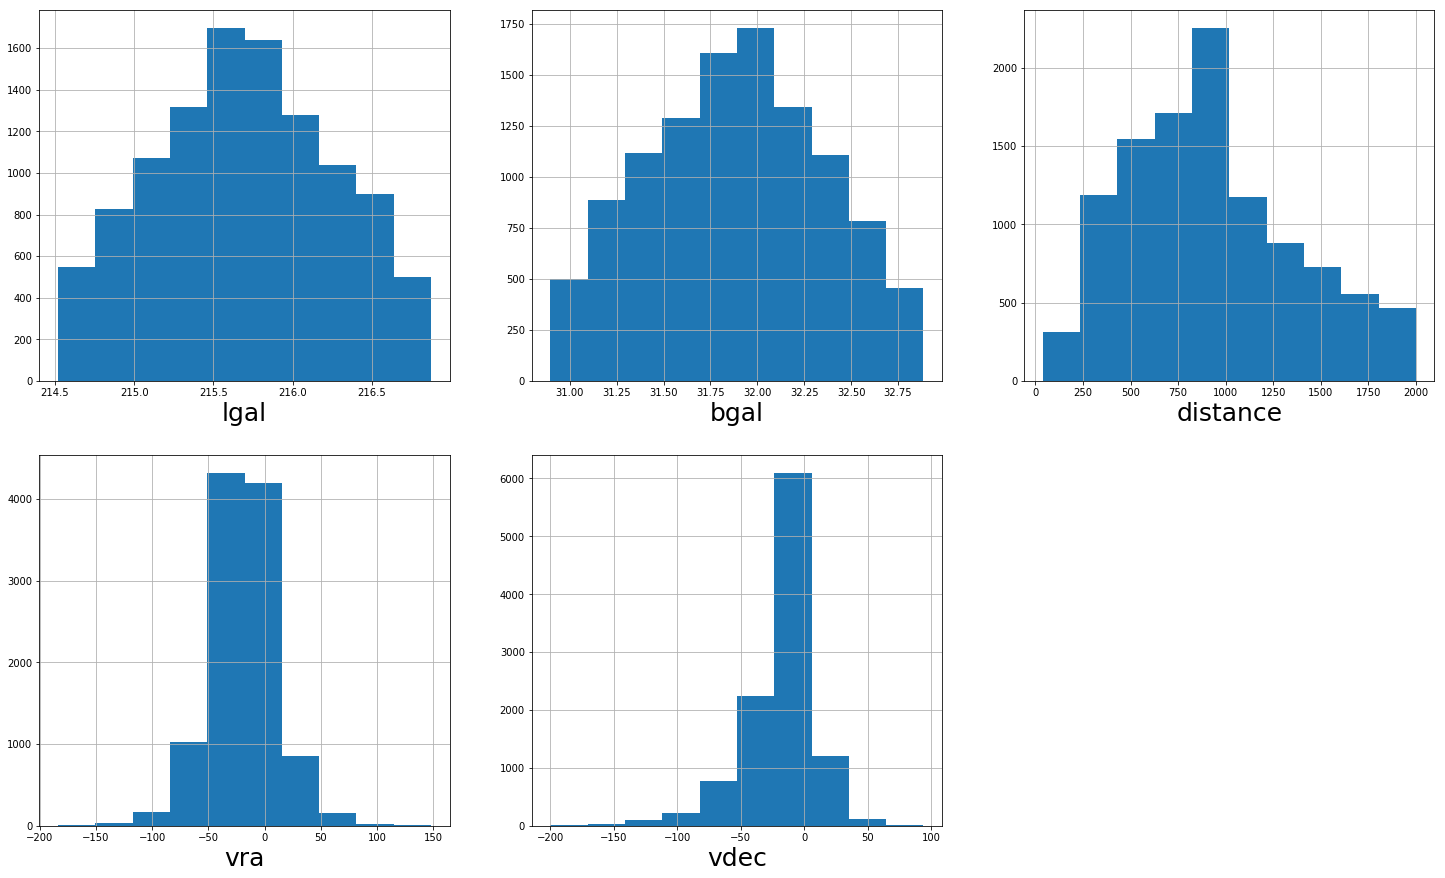

In [134]:
## Histogram
plt.figure(figsize=(25,15))
i = 1
for string in ('lgal','bgal','distance','vra','vdec'):
    plt.subplot(2,3,i)
    datapd[string].hist()
    plt.xlabel(string, fontsize=25)
    i+=1

<Figure size 1800x720 with 0 Axes>

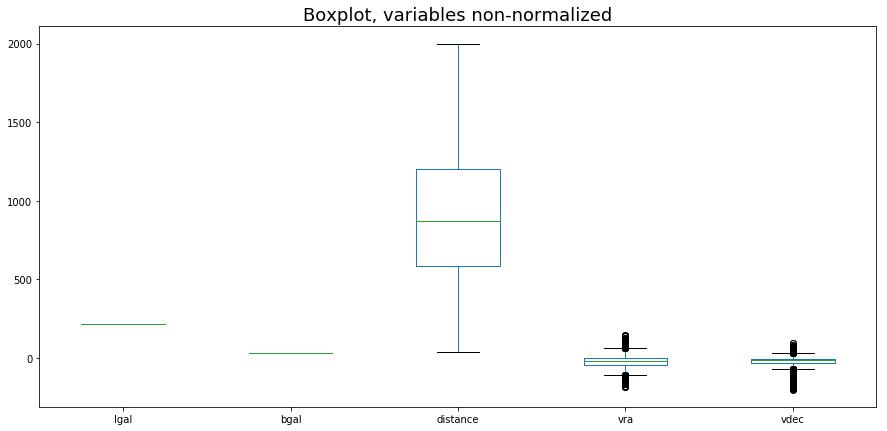

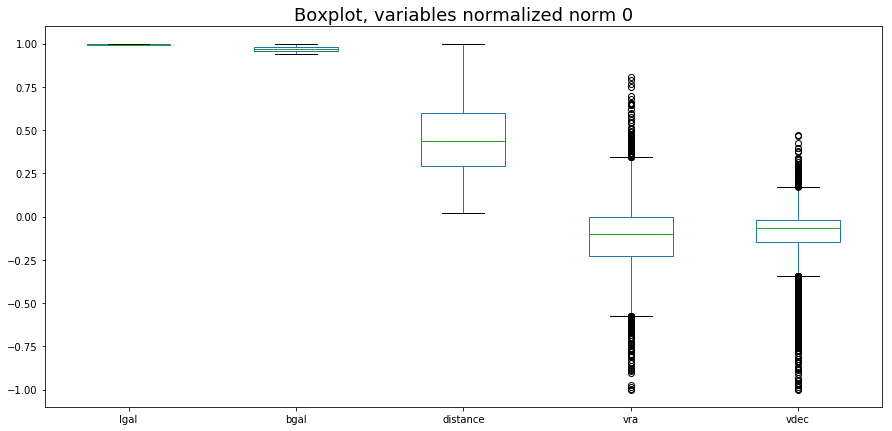

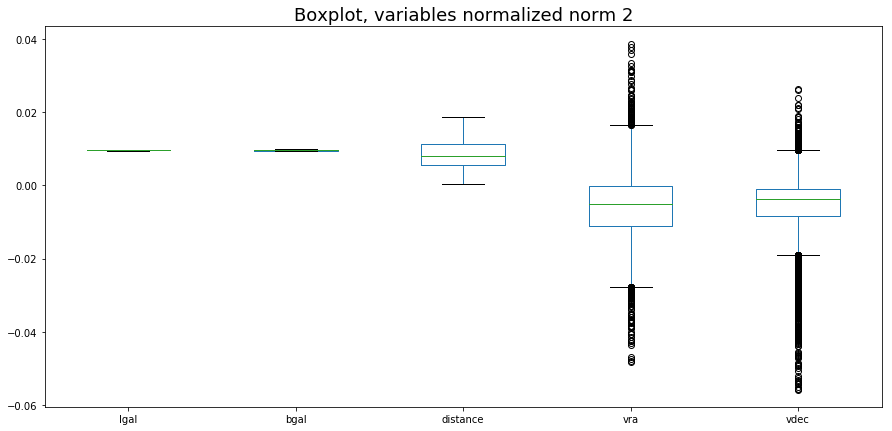

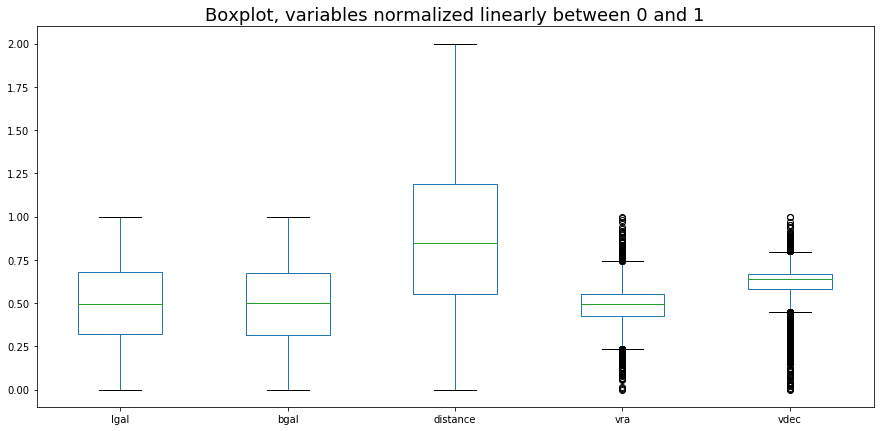

In [135]:
plt.figure(figsize=(25,10))

i = 1
string = ['non-normalized','normalized norm 0', 'normalized norm 2','normalized linearly between 0 and 1']
data_i = [datapd,datapd_nor1,datapd_nor1,datapd_nor2]
for data_i in (datapd,datapd_nor0,datapd_nor1,datapd_nor2):
    data_i.plot(kind = "box",figsize=(15, 7))
    plt.title("Boxplot, variables " + string[i-1], fontsize=18)
    i+=1


plt.show()

### Hierarchical Clustering Dendrogram

In [122]:
Z = linkage(datapd, 'ward', metric='euclidean') # choix de la distance
Z0 = linkage(datapd_nor0, 'ward', metric='euclidean') # choix de la distance
Z1 = linkage(datapd_nor1, 'ward', metric='euclidean') # choix de la distance
Z2 = linkage(datapd_nor2, 'ward', metric='euclidean') # choix de la distance

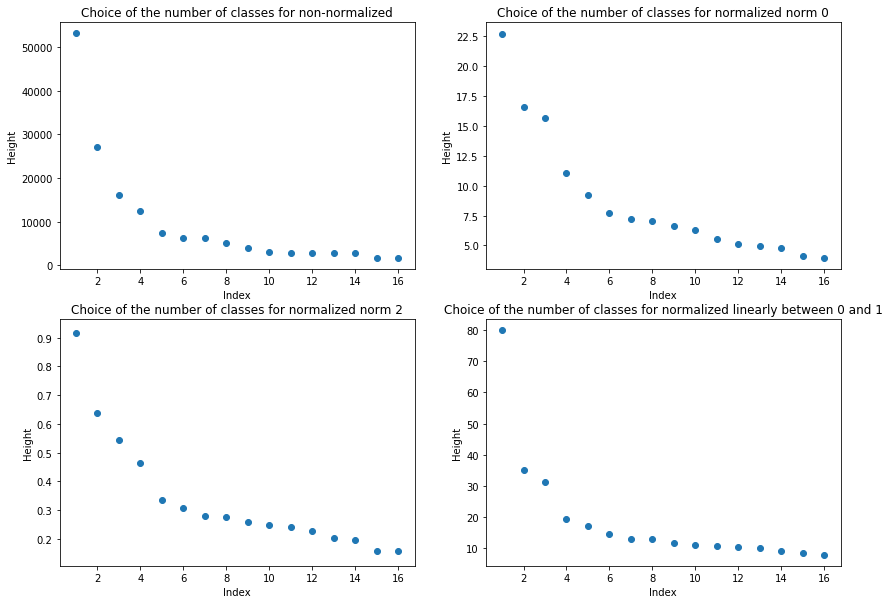

In [123]:
string = ['non-normalized','normalized norm 0', 'normalized norm 2','normalized linearly between 0 and 1']
Z_ = [Z,Z0,Z1,Z2]
t = np.zeros((16,4))
plt.figure(figsize=(14,10))
x=np.arange(16)+1
for i in range(4) :
    plt.subplot(2,2,i+1)
    height = Z_[i][:,2]
    height = sorted(height,reverse=True)
    plt.scatter(x,height[0:16])  #height[0:16]/sum(height[0:16])*100
    t[:,i] = height[0:16]
    plt.xlabel('Index')
    plt.ylabel('Height')
    plt.title("Choice of the number of classes for "+string[i])
plt.show()

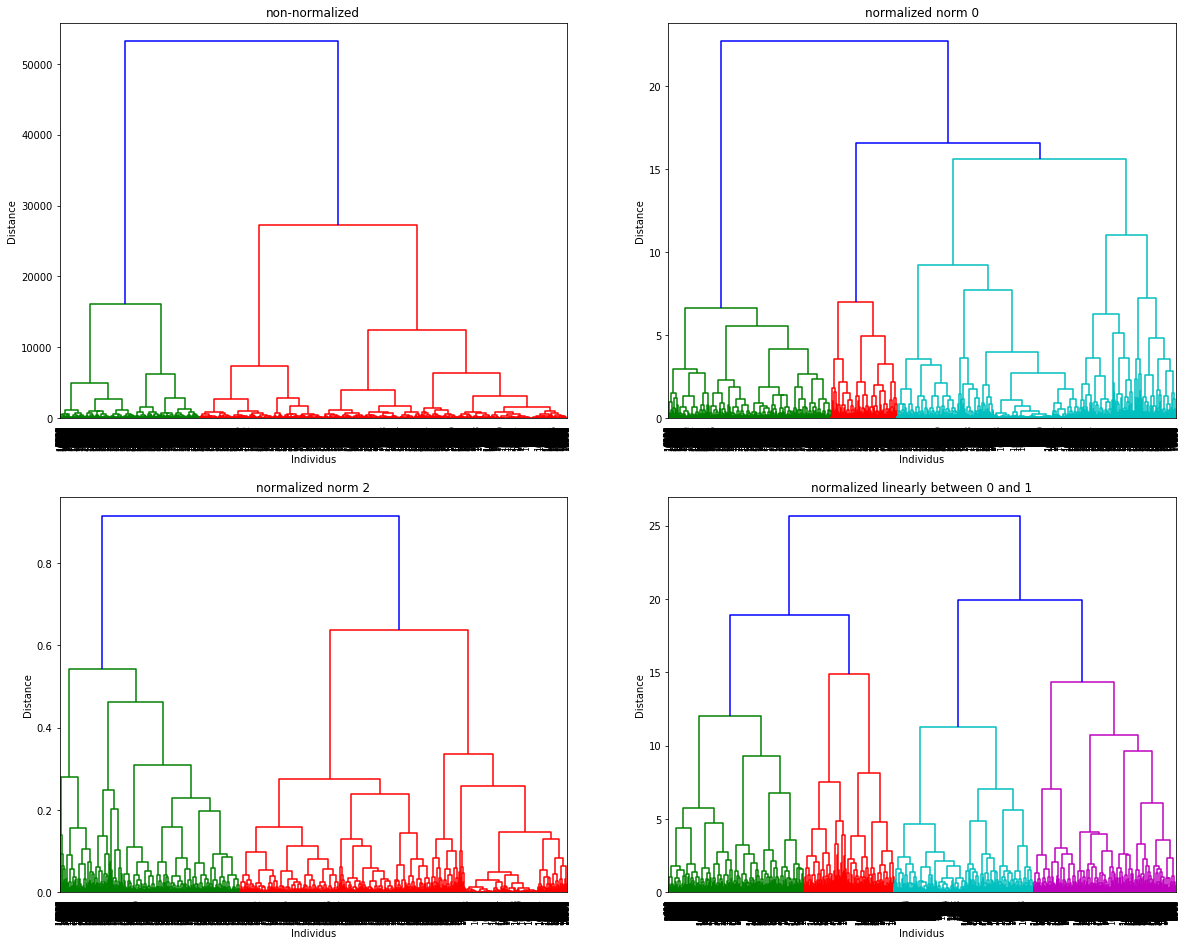

In [407]:
string = ['non-normalized','normalized norm 0', 'normalized norm 2','normalized linearly between 0 and 1']
Z_ = [Z,Z0,Z1,Z2]
data_ = [datapd, datapd_nor0, datapd_nor1, datapd_nor2]
plt.figure(figsize=(20,16))
x=np.arange(16)+1
for i in range(4) :
    plt.subplot(2,2,i+1)
    dendrogram(Z_[i],leaf_font_size=8.,labels=data_[i].index)
    plt.xlabel('Individus')
    plt.ylabel('Distance')
    plt.title(string[i])
plt.show()

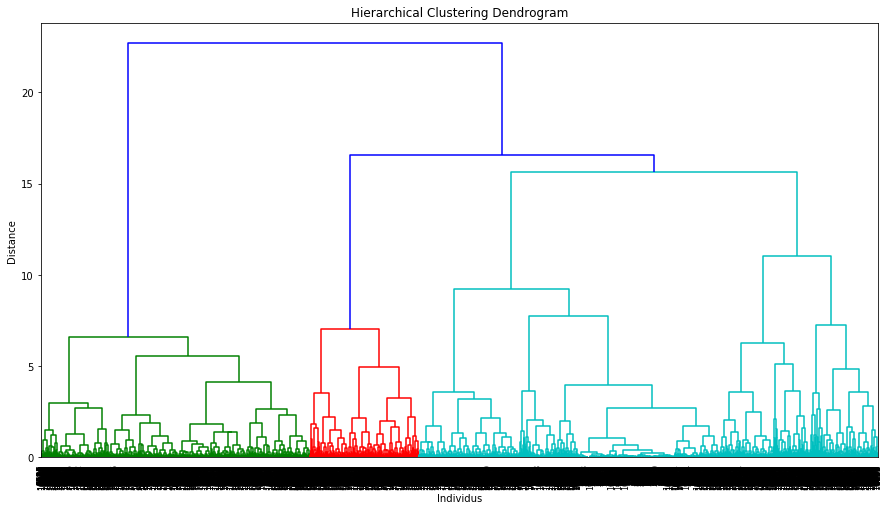

In [391]:
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Individus')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=marsRech.index)
plt.show()

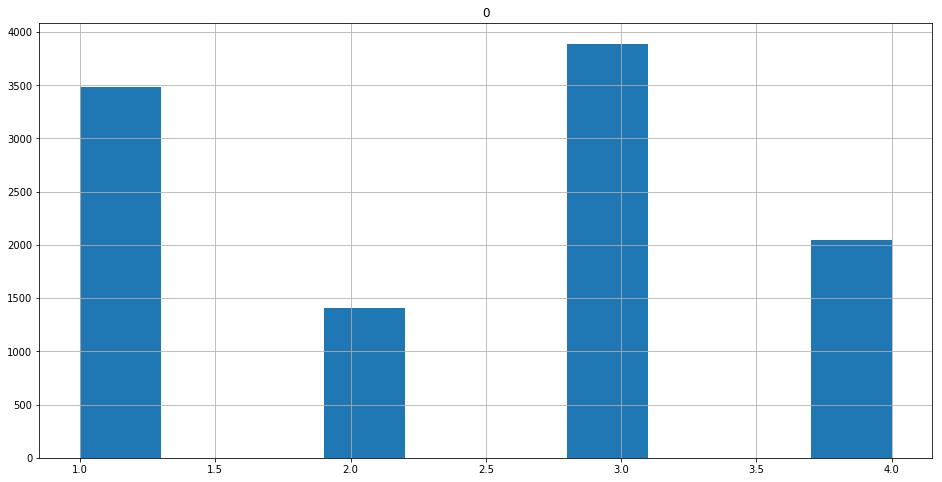

In [392]:
classesCAH = fcluster(Z,t=15,criterion='distance')
pd.DataFrame(classesCAH).hist()
plt.show()

In [251]:
print(classesCAH)

[3 3 3 ... 1 2 1]


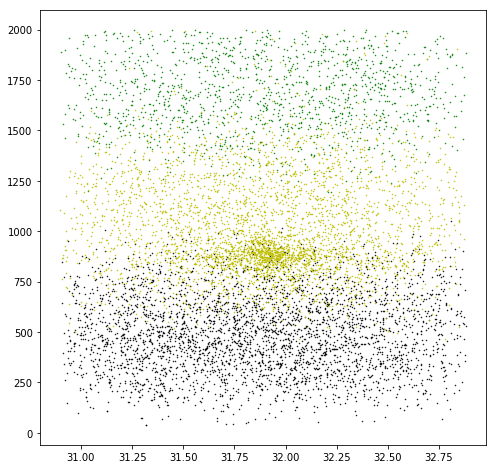

In [393]:
colors = ["r.","k.","g.","y.","b.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c."]
rcParams['figure.figsize'] = 8, 8

for i in range(4):
    ilabel = np.where(classesCAH == i)[0]
    plt.plot(datask[ilabel,1],datask[ilabel,2],colors[i],markersize=1)
    #plt.scatter(centroid_nor[0,0],centroid_nor[0,1],'y',markersize=10)
    
plt.show()

In [ ]:
colors = ["r.","k.","g.","y.","b.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c.","r.","k.","g.","y.","w.","k.","b.","g.","y.","c."]
rcParams['figure.figsize'] = 16, 8

i1 = 1
i2 = 2
string = ['non-normalized','normalized norm 0', 'normalized norm 2','normalized linearly between 0 and 1']
plt.figure(figsize=(25,22))
centro = [centroid,centroid_nor0,centroid_nor1,centroid_nor2]


for i in range(nclust):
    plt.subplot(4,3,i+1)
    ilabel = np.where(labels_nor0 == i)[0]
    plt.plot(datask[labels_nor0,i1],datask[labels_nor0,i2],colors[i],markersize=1)
    plt.plot(centroid_nor0[i,i1],centroid_nor0[i,i2],colors[i],markersize=19)
    plt.xlabel("bgal", fontsize=22)
    plt.ylabel("distance", fontsize=22)
    plt.title("cluste num. " + str(j), fontsize=22)
    
plt.show()